# Language Identification for Code-mixed Indian Languages (English_Bengali)

#### useful imports

In [36]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import nltk
from nltk.tag.util import untag
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer

#### data loading, cleaning and preparation

In [2]:
def data_loader(files):
    data = []
    sent = []
    for file in files:
        with open(file, 'r', encoding="utf-8") as temp:
            for line in temp:
                if line.strip() != '':
                    sent.append(line.strip().split('\t'))
                else:
                    if len(sent) > 0:
                        data.append(sent)
                        sent = []
    return data

In [3]:
sentences = data_loader(['data/Bengali_English_FB.txt', 'data/Bengali_English_Twitter.txt',"data/Bengali_English_SocialMedia_2015.txt"])

In [4]:
len(sentences) # total code mixed sentences in the corpus

3157

In [5]:
sentences[0] # format :  [.........,[word, language_tag, POS_tag],....]

[['fake', 'en', 'JJ'],
 ['holeo', 'bn', 'N_NNP'],
 ['proposal', 'en', 'N_NN'],
 ['pay', 'bn', 'V_VM'],
 ['na', 'bn', 'RP_NEG'],
 ['..', 'univ', 'RD_PUNC'],
 ['tora', 'bn', 'PR_PRP'],
 ['pachchis', 'bn', 'N_NN'],
 ['atleast', 'en', 'RB_AMN'],
 ['...', 'univ', 'RD_PUNC'],
 [':D', 'univ', 'E']]

##  Exploratory Data Analysis

#### putting all words (with their Language and POS tag) in the corpus in a dataframe 

In [6]:
sent_word = []
sent_lang = []
sent_pos = []

for line in sentences:
    lang = []
    word = []
    pos = []
    for word_lang_pos in line:
        word.append((word_lang_pos[0]))
        lang.append(word_lang_pos[1])
        pos.append(word_lang_pos[2])
    sent_word.append(word)
    sent_lang.append(lang)
    sent_pos.append(pos)

In [7]:
flat_df = pd.DataFrame({"word":list(itertools.chain(*sent_word)),"lang":list(itertools.chain(*sent_lang)),
                        "pos":list(itertools.chain(*sent_pos))})

In [8]:
flat_df.shape # total words = 35774

(35774, 3)

In [9]:
flat_df.head() # first five rows of the dataframe

,word,lang,pos
0,fake,en,JJ
1,holeo,bn,N_NNP
2,proposal,en,N_NN
3,pay,bn,V_VM
4,na,bn,RP_NEG


#### top 20 unique words

In [10]:
flat_df.word.value_counts()[:20]

.       1070
,        829
..       578
...      493
:        364
to       286
....     264
a        258
the      250
na       242
r        225
er       213
e        194
?        190
of       188
you      180
and      172
u        171
i        171
ami      170
Name: word, dtype: int64

#### Language Tags analysis

In [11]:
print("total language tags: ",len(np.unique(flat_df.lang)),"\n") 
print(np.unique(flat_df.lang))

total language tags:  14 

['acro' 'acro+bn_suffix' 'acro+en_suffix' 'bn' 'en' 'en+bn_suffix' 'hi'
 'mixed' 'ne' 'ne+bn_suffix' 'ne+en_suffix' 'undef' 'univ' 'univ..']


bn              0.384777
en              0.368452
univ            0.187007
ne              0.028345
hi              0.018729
acro            0.008582
undef           0.002432
ne+bn_suffix    0.000867
en+bn_suffix    0.000475
ne+en_suffix    0.000168
Name: lang, dtype: float64


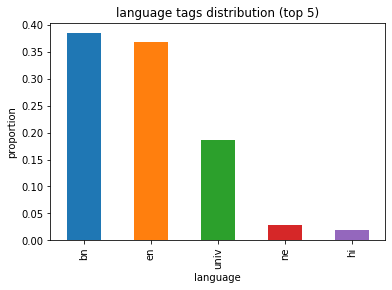

In [12]:
#plotting top 5 language tags in the dataset

(flat_df.lang.value_counts(normalize = True)[:5]).plot(kind = "bar") 
plt.xlabel("language")
plt.ylabel("proportion")
plt.title("language tags distribution (top 5)")

print(flat_df.lang.value_counts(normalize = True)[:10])

#### POS tags distribution

In [13]:
print("total POS tags: ",len(np.unique(flat_df.pos)),"\n") 
print(np.unique(flat_df.pos))

total POS tags:  39 

['#' '$' '@' 'CC' 'DM_DMD' 'DM_DMI' 'DM_DMQ' 'DM_DMR' 'DT' 'E' 'JJ' 'N_NN'
 'N_NNP' 'N_NNV' 'N_NST' 'PR_PRC' 'PR_PRF' 'PR_PRL' 'PR_PRP' 'PR_PRQ'
 'PSP' 'QT_QTC' 'QT_QTF' 'QT_QTO' 'QY_QTO' 'RB_ALC' 'RB_AMN' 'RD_ECH'
 'RD_PUNC' 'RD_RDF' 'RD_SYM' 'RP_INJ' 'RP_INTF' 'RP_NEG' 'RP_RPD' 'U'
 'V_VAUX' 'V_VM' '~']


N_NN       0.217141
RD_PUNC    0.151563
V_VM       0.125175
N_NNP      0.091659
PR_PRP     0.063258
PSP        0.062112
JJ         0.051546
RD_RDF     0.033292
DT         0.029826
RB_AMN     0.027031
Name: pos, dtype: float64


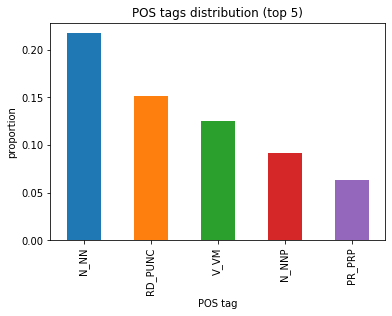

In [14]:
#plotting top 5 POS tags in the dataset

(flat_df.pos.value_counts(normalize = True)[:5]).plot(kind = "bar") 
plt.xlabel("POS tag")
plt.ylabel("proportion")
plt.title("POS tags distribution (top 5)")

print(flat_df.pos.value_counts(normalize = True)[:10])

#### POS tags distribution for English language words

N_NN      0.276686
V_VM      0.203323
PSP       0.100523
PR_PRP    0.095061
JJ        0.084212
DT        0.078143
RB_AMN    0.062059
N_NNP     0.035657
Name: pos, dtype: float64


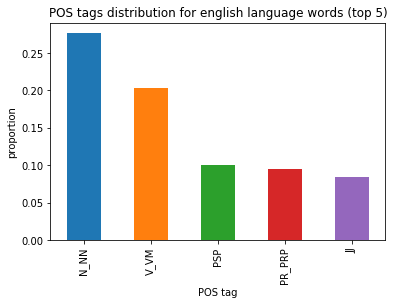

In [15]:
#plotting top 5 POS tags for english words

(flat_df.loc[flat_df.lang=="en",:].pos.value_counts(normalize = True)[:5]).plot(kind = "bar") 
plt.xlabel("POS tag")
plt.ylabel("proportion")
plt.title("POS tags distribution for english language words (top 5)")

print(flat_df.loc[flat_df.lang=="en",:].pos.value_counts(normalize = True)[:8])

In [16]:
# flat_df.to_csv("en-bn_word_distribution.csv",index=False, columns=flat_df.columns) # save data to csv for further analysis

### Data Preparation for  CRF modeling

#### selecting data for Language Identification (dropping POS tags) ; # sentences format :  [.........,[word,  language_tag],....]

In [17]:
new_sentences = []
for line in sentences:
    sent = []
    for word_lang_pos in line:
        sent.append([word_lang_pos[0],word_lang_pos[1]])
    new_sentences.append(sent)

all_sentences = np.array(new_sentences)

#### Feature extractor function : extracts features for the words of a given sentences

In [27]:
def crf_feature_extractor(sentence,index):
        """index of a perticular word whose features to be extracted """
        return {
         "word": sentence[index].lower(),
         "is_all_caps": sentence[index].upper() == sentence[index],
         "prefix-1": sentence[index][0],
         "prefix-2": sentence[index][:2],
         "prefix-3": sentence[index][:3],
         "suffix-1": sentence[index][-1],
         "suffix-2": sentence[index][-2:],
         "suffix-3": sentence[index][-3:],
         "suffix-4": sentence[index][-4:],
         "is_2_len" : 1 if len(sentence[index])==2 else 0,
         "prev_word_istitle":1 if index==1 else 0,
         "has_pun" : pun_bool(sentence[index]),
         "capitals_inside": sentence[index][1:].lower() != sentence[index][1:] }

In [28]:
def pun_bool(word):
    """ function to identify if word has any special punctuationn marks or not"""
    """function could be written more efficiently, but for time being I am just leaving it as it is"""
    sum = False
    if "!" in word:
        sum = True
    if "@" in word:
        sum = True
    if "#" in word:
        sum = True
    if "$" in word:
        sum = True
    if "%" in word:
        sum = True
    if "&" in word:
        sum = True
    if "*" in word:
        sum = True
    if "-" in word:
        sum = True
    if "_" in word:
        sum = True
    if "+" in word:
        sum = True
    if "|" in word:
        sum = True
    if ":" in word:
        sum = True
    if ";" in word:
        sum = True
    if "<" in word:
        sum = True
    if ">" in word:
        sum = True    
    if "?" in word:
        sum = True
    if "," in word:
        sum = True
    if "/" in word:
        sum = True
    return sum

In [29]:
def transform_to_dataset(tagged_sentences):
    """ function takes all the tagged sentences in the data set and for each sentence returns a list of feature dictionary 
        (1 feature dictionary per word in a sequence) and also the list of word labels of the sentences """
    
    X, y = [], []
    for tagged in tagged_sentences:
        X.append([crf_feature_extractor(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
    return X, y

### CRF modeling

#### Initial test harness : 10 fold cross validation (get average accuracy estimate)

In [111]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

accuracy = []
f1 = []

for train_index, test_index in kfold.split(all_sentences):
    
    X_train, y_train = transform_to_dataset(all_sentences[train_index])
    X_test, y_test = transform_to_dataset(all_sentences[test_index])
    
    model = CRF(c1 = 1.0, c2 = 0.001, max_iterations = 100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy.append(accuracy_score(list(itertools.chain(*y_test)),list(itertools.chain(*y_pred))))
    f1.append(metrics.flat_f1_score(y_test,y_pred,average = "weighted"))
    
print("average accuracy : ",np.round(np.mean(accuracy)*100,2),"%")
print("average f1_score : ",np.round(np.mean(f1)*100,2),"%")

average accuracy :  94.02 %
average f1_score :  93.72 %


#### Hyperparameters optimization : finding best hyperparameters which maximizes the F1 score

##### Grid Search cross validation (runnning this takes reasonable time ~ 18 minutes )

In [30]:
X,y = transform_to_dataset(all_sentences)

In [137]:
# evaluation metric will be weighted F1 score
f1_scorer = make_scorer(metrics.flat_f1_score, average="weighted")

# grid_params = {"algorithm": ["lbfgs","l2sgd"],
#                "c1": np.arange(0.4,1.3,0.1),
#                "c2" :np.arange(0.0006,0.0016,0.0002),
#                "max_iterations": [75,100,125,150]}

grid_params = {"algorithm": ["lbfgs"],
               "c1": [0.4,0.6,0.8,1.0,1.2],
               "c2" :[0.0008,0.001,0.0012,0.0014],
               "max_iterations": [75,100,125,150]}

crf_model = CRF()
kfold = KFold(n_splits = 3, random_state = 7)
grid = GridSearchCV(estimator = crf_model, param_grid = grid_params, scoring = f1_scorer, cv = kfold)

In [138]:
%%time
grid_result = grid.fit(X,y)

Wall time: 17min 11s


In [144]:
best_crf_model = grid_result.best_estimator_
best_crf_model 

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=0.4, c2=0.0014, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=75,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [145]:
grid_result.best_score_

0.9265657727561876

In [31]:
best_crf_model = CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=0.4, c2=0.0014, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=75,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

 #### 10 fold cross validation (get average accuracy estimate  with best found CRF hyperparameters)

In [146]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)

accuracy = []
f1 = []

for train_index, test_index in kfold.split(all_sentences):
    
    X_train, y_train = transform_to_dataset(all_sentences[train_index])
    X_test, y_test = transform_to_dataset(all_sentences[test_index])
    
    model = best_crf_model
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy.append(accuracy_score(list(itertools.chain(*y_test)),list(itertools.chain(*y_pred))))
    f1.append(metrics.flat_f1_score(y_test,y_pred,average = "weighted"))
    
print("average accuracy : ",np.round(np.mean(accuracy)*100,2),"%")
print("average f1_score : ",np.round(np.mean(f1)*100,2),"%")

average accuracy :  94.65 %
average f1_score :  94.4 %


<i>We can see a bit improvement in the results from the previous 10 fold cross validation</i>

#### Splitting the data into Train and Test set and fitting the model to access classification performance

In [32]:
X,y = transform_to_dataset(all_sentences)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,random_state = 7)

In [34]:
model = best_crf_model
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)

In [37]:
print("accuracy = ", np.round(metrics.flat_accuracy_score(y_test,y_pred),4))
print("f1_micro = ", np.round(metrics.flat_f1_score(y_test,y_pred, average = "micro"),4))
print("f1_weighted = ", np.round(metrics.flat_f1_score(y_test,y_pred,average = "weighted"),4))
print("f1_macro = ", np.round(metrics.flat_f1_score(y_test,y_pred,average = "macro"),4))

accuracy =  0.9388
f1_micro =  0.9388
f1_weighted =  0.936
f1_macro =  0.5851


In [155]:
## classification report
print(metrics.flat_classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        acro       0.79      0.72      0.75        68
          bn       0.93      0.96      0.95      3238
          en       0.95      0.96      0.95      3115
en+bn_suffix       0.00      0.00      0.00         3
          hi       0.78      0.57      0.66       191
          ne       0.72      0.53      0.61       257
ne+bn_suffix       1.00      0.46      0.63        13
ne+en_suffix       0.00      0.00      0.00         3
       undef       0.67      0.20      0.31        10
        univ       0.99      0.98      0.98      1671

    accuracy                           0.94      8569
   macro avg       0.68      0.54      0.59      8569
weighted avg       0.94      0.94      0.94      8569



<Figure size 720x720 with 0 Axes>

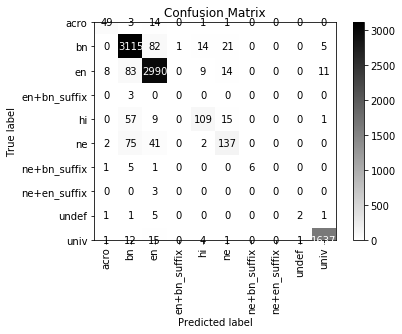

In [159]:
plt.figure(figsize=(10,10))
skplt.metrics.plot_confusion_matrix(list(itertools.chain(*y_test)),list(itertools.chain(*y_pred)),x_tick_rotation=90,cmap="binary")

## Model fitting on whole dataset for feature weights analysis 

In [160]:
X,y = transform_to_dataset(all_sentences)

In [161]:
model = best_crf_model
model.fit(X, y)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=0.4, c2=0.0014, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=75,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

#### Language transition analysis (word to word code switching)

In [162]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(model.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(model.transition_features_).most_common()[-20:])

Top likely transitions:
undef  -> undef   5.511672
hi     -> hi      5.363168
bn     -> bn      3.874080
ne     -> ne      3.843556
en     -> en      3.577426
en     -> ne      2.858931
bn     -> ne      2.507446
en     -> bn      2.497689
en     -> acro    2.409893
bn     -> en      2.170380
bn     -> en+bn_suffix 2.100491
bn     -> acro    2.019263
bn     -> univ    1.725860
en     -> hi      1.692863
en     -> univ    1.679905
en     -> undef   1.638818
acro   -> acro    1.628338
ne     -> bn      1.628179
hi     -> acro    1.618071
en+bn_suffix -> acro    1.561548

Top unlikely transitions:
ne     -> acro    0.632087
ne     -> univ    0.566266
bn     -> undef   0.482406
univ   -> univ    0.442698
univ   -> acro    0.393052
undef  -> en      0.345748
en     -> acro+en_suffix 0.292158
bn     -> hi      0.278639
acro   -> undef   0.252016
en     -> univ..  0.218355
acro   -> univ    0.198155
ne     -> en+bn_suffix 0.000366
en+bn_suffix -> en      -0.059016
hi     -> bn      -0.076191


#### Top features weights analysis (positives and negatives)

In [163]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(model.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(model.state_features_).most_common()[-30:])

Top positive:
11.021215 univ     prefix-1:@
10.210476 hi       word:dosto
8.765632 univ     suffix-2:ww
8.382627 bn       word:expectation
8.228962 univ     prefix-1:#
8.054135 ne       word:congress
7.943071 ne+en_suffix word:facebooking
7.171768 acro     word:asi
7.076435 acro     suffix-2:gl
7.063050 bn       word:foring
7.018853 mixed    word:chapless
6.995864 ne       word:presidency
6.936381 acro     word:etce
6.925031 univ     prefix-2:oo
6.822387 en       word:so
6.498872 univ     prefix-1:.
6.493849 ne       word:yd
6.222588 bn       word:er
5.891253 ne       word:facebook
5.832261 ne       word:chaitro
5.811712 en       suffix-2:ck
5.774555 en       word:no
5.704226 hi       word:bhag
5.697798 en       suffix-3:ear
5.606215 hi       word:chutiyapa
5.579611 en       word:she
5.571446 en       suffix-2:ic
5.556683 acro     word:dslr
5.525105 en       word:rathe
5.511917 en       suffix-3:tie

Top negative:
-1.840711 bn       prefix-1:w
-1.853365 en       word:fest
-1.854499 uni